# Manage Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import time # for tracking of model training time


## Specify our model version

In [2]:
# latest model version is v19, with the extra banana images supplied by cody
model_version = 'v19'

# Getting image data

In [3]:
import pathlib
import os

In [4]:
data_dir = 'data'

In [5]:
# # Remove invalid format images
# import cv2
# import imghdr
# data_dir = 'data' 
# image_exts = ['jpeg','jpg', 'bmp', 'png']
# # remove images with invalid file formats
# for image_class in os.listdir(data_dir):
#     for image in os.listdir(os.path.join(data_dir,image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try:
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts:
#                 print("Image not in ext list {}".format(image_path))
#                 os.remove(image_path)
#         except Exception as e:
#             print('Issue with image {}'.format(image_path))
#             #os.remove(image_path)

# Defining model parameters

In [6]:
batch_size = 32
img_height = 180
img_width = 180

# Defining training and validation split
Model v3 has a Train-Validate-Test ration of 80-10-10

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16790 files belonging to 3 classes.
Using 13432 files for training.
Found 16790 files belonging to 3 classes.
Using 3358 files for validation.


In [8]:
# print("Validate and test batches: " + str(val_ds.cardinality().numpy()) + "\n")
# Calculate the split point (assuming even split for simplicity)
split_point = val_ds.cardinality().numpy() // 2

# Create test_ds by taking the first half
test_ds = val_ds.take(split_point)

# Create val_ds by skipping the first half
val_ds = val_ds.skip(split_point)

print("Training batches: " + str(train_ds.cardinality().numpy()))
print("Validate batches: " + str(val_ds.cardinality().numpy()))
print("Test batches: " + str(test_ds.cardinality().numpy()))

Training batches: 420
Validate batches: 53
Test batches: 52


### Analyse the class names

In [9]:
class_names = train_ds.class_names
print(class_names)

['banana', 'lemon', 'unknown']


## Visualise our images

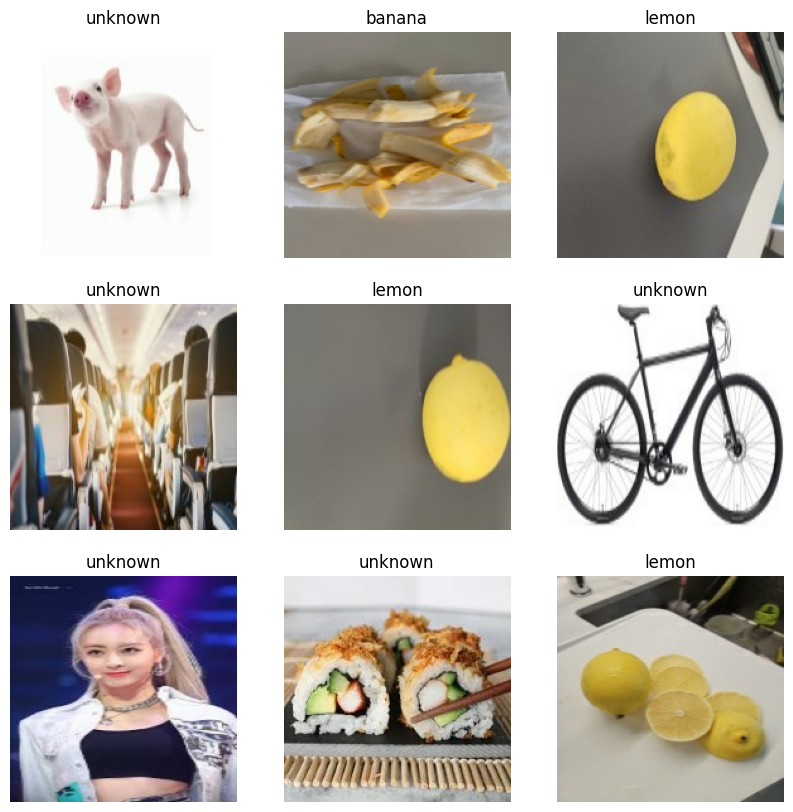

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Configure the dataset for performance

In [11]:
'''

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch overlaps data preprocessing and model execution while training.

'''

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Standardize the data
THe RGB values are in the range of 0-255, which is not ideal for ML.
Therefore we will standardize them to [0,1]

THe line of code below is just to demonstrate the use of layers.Rescaling. Our model will already include this layer within it's architecture (see subsequent lines)

In [12]:
normalization_layer = layers.Rescaling(1./255)


## Rotating images instances to assist with overfitting problems

In [13]:
# data augmentation to reduce overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


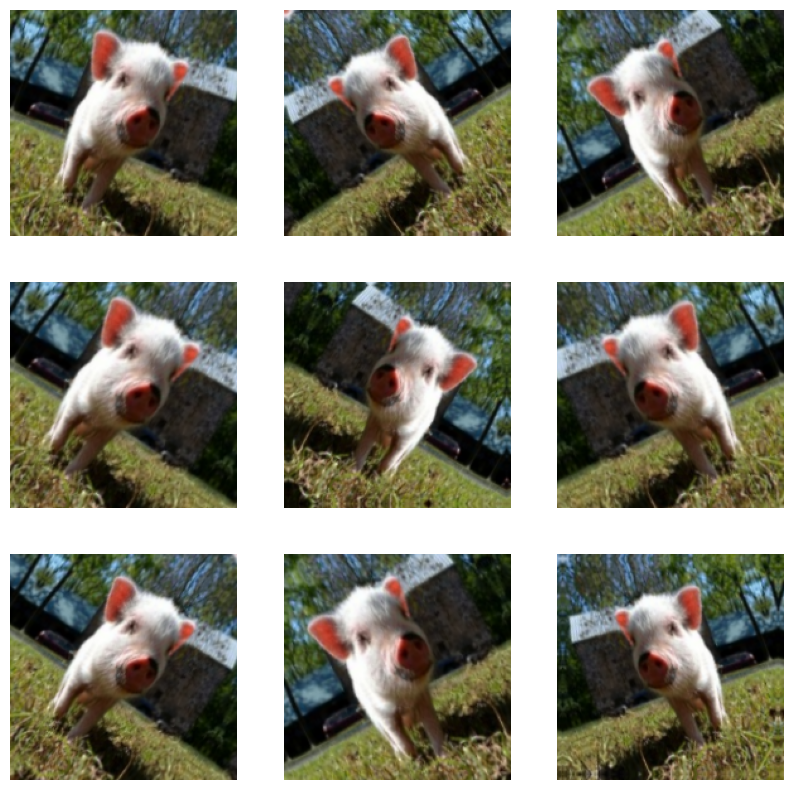

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


# Building the Model

In [15]:
# creating model
# re-scalling is done within the model building process already

num_classes = len(class_names)

# Choose an appropriate regularization strength (e.g., 0.01)
l2_strength = 0.001

# Applying Dropout to the model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l2_strength)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l2_strength)),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(l2_strength)),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(l2_strength)),
  layers.Dense(num_classes, name="outputs")
])



## Introduce early stopping

In [16]:
# Stop training when the loss stopped improving. Optimizes model training time.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

## Compile the model

In [17]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

 ## Summarize the model

In [18]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

## Train the model

In [19]:
epochs = 15

# Record the start time
start_time = time.time()

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[callback]
)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Convert elapsed time to minutes and seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

# Print the elapsed time in minutes and seconds
print(f"Time taken: {minutes} minutes and {seconds} seconds")


Epoch 1/15


420/420 [==============================] - 61s 143ms/step - loss: 0.4695 - accuracy: 0.8701 - val_loss: 0.2450 - val_accuracy: 0.9569
Epoch 2/15
420/420 [==============================] - 64s 152ms/step - loss: 0.2634 - accuracy: 0.9497 - val_loss: 0.2128 - val_accuracy: 0.9593
Epoch 3/15
420/420 [==============================] - 56s 132ms/step - loss: 0.2076 - accuracy: 0.9666 - val_loss: 0.2537 - val_accuracy: 0.9457
Epoch 4/15
420/420 [==============================] - 55s 130ms/step - loss: 0.1887 - accuracy: 0.9698 - val_loss: 0.1660 - val_accuracy: 0.9723
Epoch 5/15
420/420 [==============================] - 55s 130ms/step - loss: 0.1667 - accuracy: 0.9758 - val_loss: 0.1380 - val_accuracy: 0.9876
Epoch 6/15
420/420 [==============================] - 54s 130ms/step - loss: 0.1556 - accuracy: 0.9780 - val_loss: 0.1494 - val_accuracy: 0.9793
Epoch 7/15
420/420 [==============================] - 56s 133ms/step - loss: 0.1523 - accuracy: 0.9783 - val_loss: 0.1315 - val_

## Visualise training results

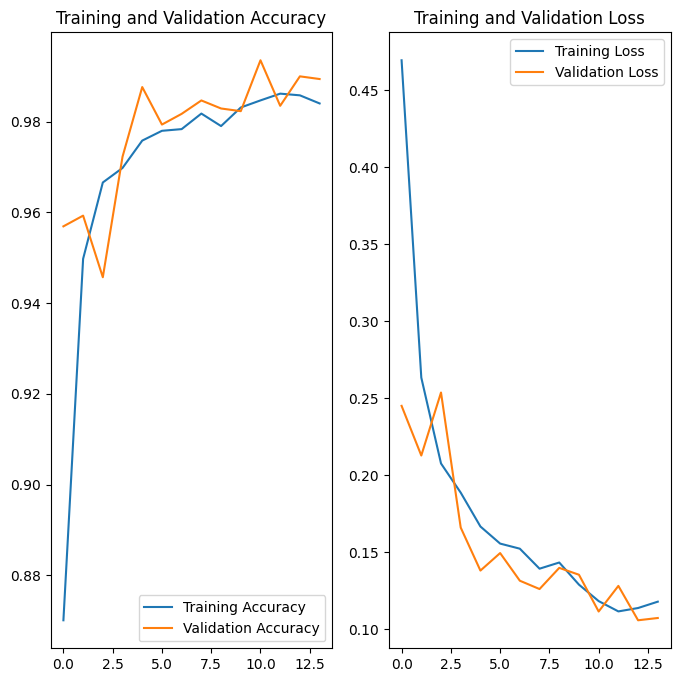

Time taken: 13 minutes and 30 seconds


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))
# print(epochs_range)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Print the elapsed time in minutes and seconds...again
print(f"Time taken: {minutes} minutes and {seconds} seconds")

# Saving the model 
### (IMPORTANT: Rename the version to the one currently worked on)

In [21]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('./models/my_model_' + model_version + '.h5')


C:\Users\Ryan Chan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predicting on new data

## Predicting with the test batch

In [22]:
# Evaluate the model on the test dataset
evaluation_result = model.evaluate(test_ds)

# Retrieve metric names
metric_names = model.metrics_names

# Print the evaluation result with metric names
for name, result in zip(metric_names, evaluation_result):
    print(f"{name}: {result}")

52/52 [==============================] - 2s 32ms/step - loss: 0.1003 - accuracy: 0.9892
loss: 0.100347600877285
accuracy: 0.989182710647583


### Getting python version (for debugging purposes)

In [23]:
import sys  # Import the sys module to access system-specific parameters and functions

# Print the Python version to the console
print("Python version")

# Use the sys.version attribute to get the Python version and print it
print(sys.version)

# Print information about the Python version
print("Version info.")

# Use the sys.version_info attribute to get detailed version information and print it
print(sys.version_info)

Python version
3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)


## Predict an image from the internet

In [27]:
# lemon: https://freefoodphotos.com/imagelibrary/fruit/lemon.jpg
# banana: https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Banana-Single.jpg/640px-Banana-Single.jpg
# unknown: https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Garden_strawberry_%28Fragaria_%C3%97_ananassa%29_single2.jpg/800px-Garden_strawberry_%28Fragaria_%C3%97_ananassa%29_single2.jpg

model = tf.keras.models.load_model('models/my_model_v19.h5')

test_url = input("enter url: ")
test_path = tf.keras.utils.get_file(origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# # outputting predictions for each image
# score = tf.nn.softmax(predictions[0])
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

# outputting predictions for each image
softmax_scores = tf.nn.softmax(predictions[0])
predicted_class_index = np.argmax(softmax_scores)

# Print the probabilities for each class
for i, class_name in enumerate(class_names):
    confidence = 100 * softmax_scores[i]
    print("Probability for {}: {:.2f} percent".format(class_name, confidence))

# Print the predicted class
print("This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[predicted_class_index], 100 * np.max(softmax_scores)))

enter url:  https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Banana-Single.jpg/640px-Banana-Single.jpg


1/1 [==============================] - 0s 73ms/step
Probability for banana: 92.38 percent
Probability for lemon: 0.51 percent
Probability for unknown: 7.11 percent
This image most likely belongs to banana with a 92.38 percent confidence.
